<a href="https://colab.research.google.com/github/chris-hoertnagl/pytorch-practice/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
# hyper parameters
num_epochs = 20
batch_size = 4
learning_rate = 0.001

# Data

In [44]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [45]:
# CIFAR 10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [46]:
classes = ('plane', 'car', 'brid', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# CNN Model

## CNN Test

In [47]:
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

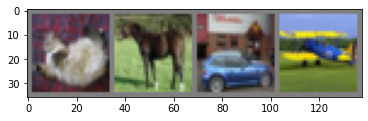

In [48]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [49]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
print(images.shape)
x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 10, 10])
torch.Size([4, 16, 5, 5])


# Model implementation and Training

In [55]:
# CNN Model
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120) # 120 can be varied & 16 * 5 * 5 is explained in above cell
    self.fc2 = nn.Linear(in_features=120, out_features=84) # 84 can be varied
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


In [56]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [57]:
# training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backwardd and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 2000 == 0:
      print(f'epoch {epoch + 1} / {num_epochs}, step {i+1} / {n_total_steps}, loss {loss.item():4f}')

epoch 1 / 20, step 2000 / 12500, loss 2.296976
epoch 1 / 20, step 4000 / 12500, loss 2.316215
epoch 1 / 20, step 6000 / 12500, loss 2.297006
epoch 1 / 20, step 8000 / 12500, loss 2.288189
epoch 1 / 20, step 10000 / 12500, loss 2.296183
epoch 1 / 20, step 12000 / 12500, loss 2.288343
epoch 2 / 20, step 2000 / 12500, loss 2.103952
epoch 2 / 20, step 4000 / 12500, loss 2.188032
epoch 2 / 20, step 6000 / 12500, loss 2.303839
epoch 2 / 20, step 8000 / 12500, loss 2.877079
epoch 2 / 20, step 10000 / 12500, loss 1.965429
epoch 2 / 20, step 12000 / 12500, loss 1.208664
epoch 3 / 20, step 2000 / 12500, loss 1.960305
epoch 3 / 20, step 4000 / 12500, loss 1.476115
epoch 3 / 20, step 6000 / 12500, loss 1.754966
epoch 3 / 20, step 8000 / 12500, loss 1.770411
epoch 3 / 20, step 10000 / 12500, loss 1.480139
epoch 3 / 20, step 12000 / 12500, loss 2.009543
epoch 4 / 20, step 2000 / 12500, loss 1.241323
epoch 4 / 20, step 4000 / 12500, loss 1.470395
epoch 4 / 20, step 6000 / 12500, loss 1.013337
epoch 4

In [58]:
# test code
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Overall accuracy: {acc}%')
  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')



Overall accuracy: 60.98%
Accuracy of plane: 59.8 %
Accuracy of car: 85.2 %
Accuracy of brid: 45.8 %
Accuracy of cat: 50.3 %
Accuracy of deer: 49.2 %
Accuracy of dog: 38.0 %
Accuracy of frog: 83.4 %
Accuracy of horse: 63.4 %
Accuracy of ship: 79.2 %
Accuracy of truck: 55.5 %
